# Machine Vision<br>Assignment 5 - Recognition

## Personal details

* **Name(s):** `Hao Ban.`
* **Student ID(s):** `2591928.`

## 1. Introduction

In this assignment, our goal is to classify apples and pears using the shape and color features. The figure below shows examples from both classes. There is a slight color difference between the apples and pears. Therefore, we will use the hue of the fruit as our first feature $x_1$. Depending on the viewpoint, the apples are generally more round compared to pears. To represent the roundness, we will use the eccentricity as our second feature $x_2$. The eccentricity will vary between 0 and 1 (the eccentricity of a circe is zero). The features can be combined into a feature vector $\mathbf{x} = [x_1, x_2]^\top$.

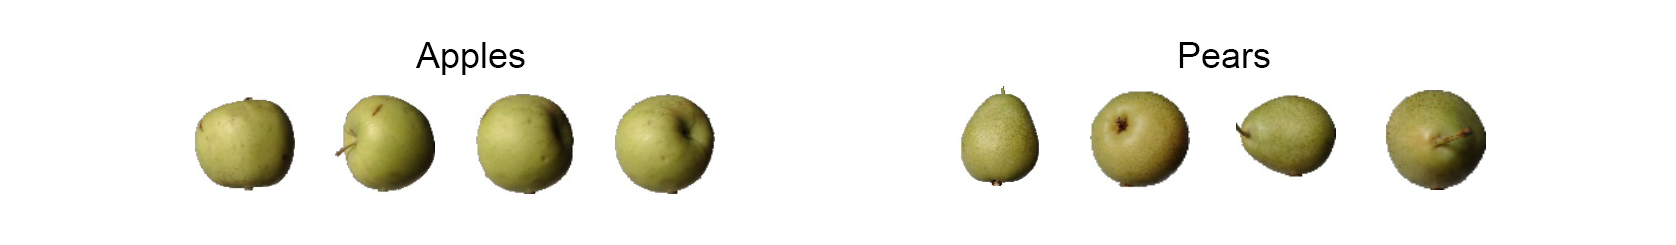

We can utilize techniques from the previous assignments to compute features (such as the eccentricity and hue) from the images. The focus of this assignment is, however, in the classification. The features and class labels have been precomputed and saved to `class_data.npz` file. We first read and visualize the samples.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors.nearest_centroid import NearestCentroid

# Load data
data=np.load('class_data.npz')
X_train = data['arr_0'] # Nx2 matrix
y_train = data['arr_1'] # 1xN vector
X_test = data['arr_2']  # Mx2 matrix
y_test = data['arr_3']  # 1xM vector

# We print a few feature vectors and the 
# corresponding true classes
print(X_train[:4,:])
print(y_train[:4])

# Visualize training data
yp = y_train == 'pear'
ya = y_train == 'apple'
X1 = X_train[yp,:]
X2 = X_train[ya,:]

fig, ax = plt.subplots()
ax.scatter(X1[:,0], X1[:,1], c='r', label='pear')
ax.scatter(X2[:,0], X2[:,1], c='b', label='apple')
ax.set_xlabel('$x_1$ (hue)')
ax.set_ylabel('$x_2$ (eccentricity)')
ax.set_title('Training data')
ax.legend()

## 2. Classification (Euclidean distance)

**2.1. Nearest centroid classifier** $\quad$ <font color=red>(0.25 points)</font>

Complete the following code cell. You need to classify the test samples using the __[`nearest centroid classifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html)__. First, you should train the classifier using the training samples `X_train` and `y_train`. See the example __[`Recognition.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Recognition.ipynb)__ for more information. Use the Euclidean distance as a distance metric. Evaluate the performance of the classifier using independent test data `X_test` and true labels `y_test`. That is, print the mean accuracy the same ways as in the sample code.

In [ ]:
# ---------- YOUR CODE STARTS HERE -----------

nc = NearestCentroid()
# Train the classifier using the fit() method
nc.fit(X_train,y_train)

# Print the mean accuracy using the score() method

nc.score(X_test,y_test)

# ---------- YOUR CODE ENDS HERE -----------

*Hint:*  Your code should be correct if the mean accuracy is 0.70.

**2.2. Visualization** $\quad$ <font color=red>(0.50 points)</font>

Complete the following code cell. Plot the test data (`X_test`, `y_test`) the same way we plotted the training data. You should also display the class centroids and the decision boundary between the classes. Again, take a look at the sample code __[`Recognition.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Recognition.ipynb)__. Please do not overwrite the training feature vectors `X1` and `X2` as we will use them later.

In [ ]:
# ---------- YOUR CODE STARTS HERE -----------
yp = y_test == 'pear'
ya = y_test == 'apple'
X3 = X_test[yp,:]
X4 = X_test[ya,:]

y_pred = nc.predict(X_test)
tp = np.logical_and(y_test == 'P', y_pred == 'P')
tn = np.logical_and(y_test == 'N', y_pred == 'N')
fp = np.logical_and(y_test == 'N', y_pred == 'P')
fn = np.logical_and(y_test == 'P', y_pred == 'N')

x, y = np.meshgrid(np.linspace(22,30,1000),np.linspace(0.25,0.65,1000))
grid = np.vstack((x.flatten(), y.flatten())).T
db = (nc.predict(grid)).reshape(1000,1000)
db = (db == 'pear').astype(np.uint8)

fig, ax = plt.subplots()
ax.scatter(X3[:,0], X3[:,1], c='r', label='pear')
ax.scatter(X4[:,0], X4[:,1], c='b', label='apple')
ax.scatter(nc.centroids_[:,0],nc.centroids_[:,1], c='g', marker='+', s=100)
ax.contour(x, y, db, 1)
ax.set_xlabel('$x_1$ (hue)')
ax.set_ylabel('$x_2$ (eccentricity)')
ax.set_title('Testing data')
ax.legend()


# ---------- YOUR CODE ENDS HERE -----------

*Hint:* It is not necessary to display the true positives (TP), true negatives (TN), false positives (FP) and false negatives (FN) as in the sample code. However, you should use at least two different colors (red and blue) to indicate pears and apples the same way as before.

## 3. Classification (Mahalanobis distance)

Notice that features (eccentricity and hue) are not measured in the same units. The drawback with Euclidean distance is that it gives equal weights to all dimensions. The clusters that we are trying to model are not spherical so the Euclidean distance does not give an accurate distance. We can model both clusters as multivariate Gaussian distributions with a mean $\mu$ and covariance matrix $\sum$. This implicitly represents the region as an ellipsoid centered at $\mu$ with the axes aligned with the eigenvectors of $\sum$.

The Mahalanobis distance provides an adequate distance in this case, weighting each dimension according to the observed variance and taking into account covariance of different dimensions. The equation for the Mahalanobis distance is:

$$
d_M^i = \sqrt{(\mathbf{x}-\mathbf{\mu}_i)^\top \sum{}{}_{i}^{-1} (\mathbf{x}-\mathbf{\mu}_i)} \qquad \qquad (1).
$$

In this case, the inverse covariance matrix $\sum^{-1}$ is a 2 x 2 matrix as we have two features.

**3.1. Compute means and covariances** $\quad$ <font color=red>(0.25 points)</font>

Complete the following code cell. Compute the means (centroids) $\mathbf{\mu}_1$ and $\mathbf{\mu}_2$ of the training samples `X1` and `X2`. You can use the function __[`np.mean()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html)__. The means should be the same as before (plotted in Sec. 2.2.). You should also compute the covariance matrices $\sum_1$ and $\sum_2$ using __[`np.cov()`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.cov.html)__. These should be 2 x 2 matrices (see the *rowvar* parameter). Print the means and covariances.

In [ ]:
# ---------- YOUR CODE STARTS HERE -----------


# Compute means (mean1, mean2)
mean1 = [np.mean(X1[:,0]),np.mean(X1[:,1])]
mean2 = [np.mean(X2[:,0]),np.mean(X2[:,1])]
means = np.array([mean1,mean2],float)
# Compute covariance matrices (cov1, cov2)
cov1 = np.cov(X1,rowvar=False)
cov2 = np.cov(X2,rowvar=False)

print(means)
print(cov1)
print(cov2)
# ---------- YOUR CODE ENDS HERE -----------

**3.2. Compute Mahalanobis distances** $\quad$ <font color=red>(0.50 points)</font>

Complete the following code cell. The function `mahalanobisDistances()` should compute Mahalanobis distances between the samples `X` and centroids $\mathbf{\mu}_1$ and $\mathbf{\mu}_2$. Use the formula 1. The function should return a vector of distances `dists`.

In [ ]:
# INPUT   
# X    : Feature vectors of the test samples (Mx2 matrix)
# mean : The mean feature (centroid) of the class (1x2 vector)
# cov  : Covariance matrix of the class (2x2 matrix)
#
# OUTPUT  
# dists : Mahalanobis distances between the test samples 'X'
#         and the centroid 'mean' (1xM vector)
#
def mahalanobisDistances(X, mean, cov):
    
    # ---------- YOUR CODE STARTS HERE -----------
    
    M = X.shape[0] # Number of samples
    dists = np.zeros(M)
    
    
    # Compute the inverse of the covariance matrix
    incov = np.linalg.inv(cov)
    
    # Compute Mahalanobis distances
    for i in range(M):
        dists[i] = np.sqrt(np.dot(np.dot((X[i] - mean).T,incov),(X[i] - mean)))                         
    
    
    # ---------- YOUR CODE ENDS HERE -----------
    return dists
                

*Hints:* 
- Notice that you need to compute the inverse of the covariance matrix $\sum{}{}^{-1}$. You can use __[`np.linalg.inv()`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.linalg.inv.html)__.


Once you have completed the function, uncomment the following code. Note that you may need to modify the first two lines so that the function call is compatible with your naming of the variables.

In [ ]:
# Uncomment the following section once you have
# computed the Mahalanobis distances. You may
# have to to modify the first two lines of code.
    
#'''

# ---------- YOUR CODE STARTS HERE -----------

D1 = mahalanobisDistances(X_test, mean1, cov1)
D2 = mahalanobisDistances(X_test, mean2, cov2)

# ---------- YOUR CODE ENDS HERE -----------


# Produce class labels based on the distances
idx = D1 < D2
y_pred = np.array(D1.shape[0]*['apple'])
y_pred[idx == True] = 'pear'

# Compute mean accuracy
score = np.sum(y_test == y_pred) / y_test.shape[0]
print('Score = %f' %score)

#'''


*Hint:*  
- Your code should be correct if the mean accuracy is 0.92.
- If the convariance matrices are identity matrices $\sum = \mathbf{I}$, Mahalanobis distance becomes Euclidean distance. The score should then be the same as in Sec. 2.1. (score = 0.70). This is just another way to test your code.

**3.3. In what units is the Mahalanobis distance?** $\quad$ <font color=red>(0.50 points)</font>

`No unit.`

# Aftermath
Finally, fill your answers to the following questions:

**How much time did you need to complete this exercise?**

`1 h.`

**Did you experience any problems with the exercise? Was there enough help available? Should this notebook be more (or less) detailed?**

`I am not sure that the answer of section 3.3 is correct. Others are ok for me.`

# References
`None.`

# Submission

1. Click on the menu `Kernel -> Restart & Clear Output` to clear all outputs and variables, etc.
2. Compress the resulting Jupyter notebook (`MV_A5.ipynb` file) into **`MV_A5_[student number(s)].zip`** (e.g. `MV_A5_1234567.zip` if solo work or `MV_A5_1234567-7654321.zip` if pair work).
3. Send an email to janne.mustaniemi@oulu.fi with the subject line `MV_A5_[student number(s)]`. Remember to attach the .zip file.

**Deadline of the assignment 18.2.2019**